# Importação das bibliotecas

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter


# Leitura da Base

In [222]:
df = pd.read_csv("/content/drive/MyDrive/PCD1/assets/data/bases_modificadas/State_of_Data_dados_tratados.csv")

# Definição do Atributo alvo

In [223]:
y = df['progressao_prejudicada']
X = df.drop('progressao_prejudicada', axis=1)

# Balanceamento com Smote

In [224]:
# 2. Definir a variável alvo e remover registros onde ela é nula
TARGET_COLUMN = 'progressao_prejudicada'

# 6. Aplicar o SMOTE
print("Aplicando SMOTE para balancear as classes...")
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

print("SMOTE concluído.")
print("-" * 50)



Aplicando SMOTE para balancear as classes...
SMOTE concluído.
--------------------------------------------------


# Separação em treino e teste

In [225]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y
)

Instanciando o modelo de Random Forest

In [226]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None

)

rf_model.fit(X_train, y_train)


scores = cross_val_score(rf_model, X, y, cv=5)
scores


array([0.75302115, 0.97432024, 0.97280967, 0.96598639, 0.97808012])

Acurácia treino: 0.9998222222222222

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2813
         1.0       1.00      1.00      1.00      2812

    accuracy                           1.00      5625
   macro avg       1.00      1.00      1.00      5625
weighted avg       1.00      1.00      1.00      5625



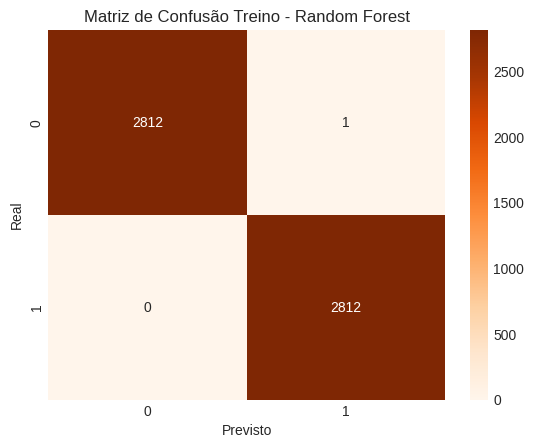

Acurácia teste: 0.9486404833836858

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       496
         1.0       0.97      0.93      0.95       497

    accuracy                           0.95       993
   macro avg       0.95      0.95      0.95       993
weighted avg       0.95      0.95      0.95       993



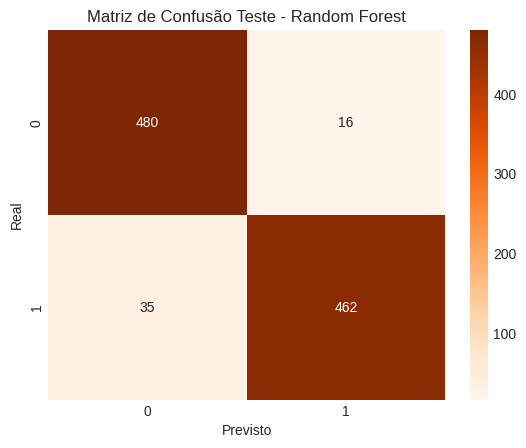

In [227]:
y_pred_tr = rf_model.predict(X_train)

print("Acurácia treino:", accuracy_score(y_train, y_pred_tr))
print("\nRelatório de Classificação:\n", classification_report(y_train, y_pred_tr))

# Matriz de Confusão de treino
cm = confusion_matrix(y_train, y_pred_tr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão Treino - Random Forest")
plt.show()



y_pred_te = rf_model.predict(X_test)

print("Acurácia teste:", accuracy_score(y_test, y_pred_te))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_te))

# Matriz de Confusão de treino
cm = confusion_matrix(y_test, y_pred_te)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão Teste - Random Forest")
plt.show()

Treinando o modelo com diferentes profundidades...
Treinamento concluído.
--------------------------------------------------
Gráfico salvo como 'acuracia_treino_vs_teste.png'


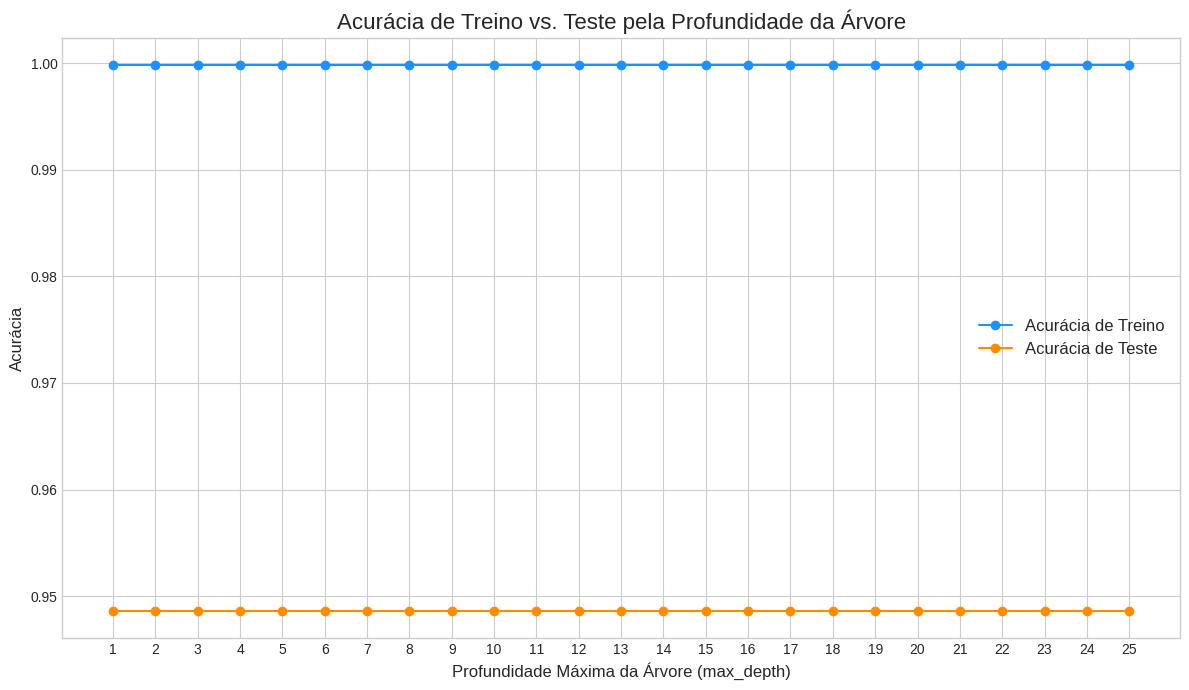

In [228]:

import matplotlib.pyplot as plt
import seaborn as sns


# --- 3. Treinamento do Modelo em Loop e Coleta das Acurácias ---
# Vamos testar diferentes profundidades para a árvore, de 1 a 25
depths = range(1, 26)
train_accuracies = []
test_accuracies = []

print("Treinando o modelo com diferentes profundidades...")
for depth in depths:

    # Fazer predições e calcular a acurácia para os dados de TREINO
    y_train_pred = rf_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_acc)

    # Fazer predições e calcular a acurácia para os dados de TESTE
    y_test_pred = rf_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)

print("Treinamento concluído.")
print("-" * 50)


# --- 4. Geração do Gráfico ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

plt.plot(depths, train_accuracies, 'o-', color='dodgerblue', label='Acurácia de Treino')
plt.plot(depths, test_accuracies, 'o-', color='darkorange', label='Acurácia de Teste')

plt.title('Acurácia de Treino vs. Teste pela Profundidade da Árvore', fontsize=16)
plt.xlabel('Profundidade Máxima da Árvore (max_depth)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.xticks(depths)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Salvar o gráfico
plt.savefig('acuracia_treino_vs_teste.png')
print("Gráfico salvo como 'acuracia_treino_vs_teste.png'")

# Exibir o gráfico
plt.show()

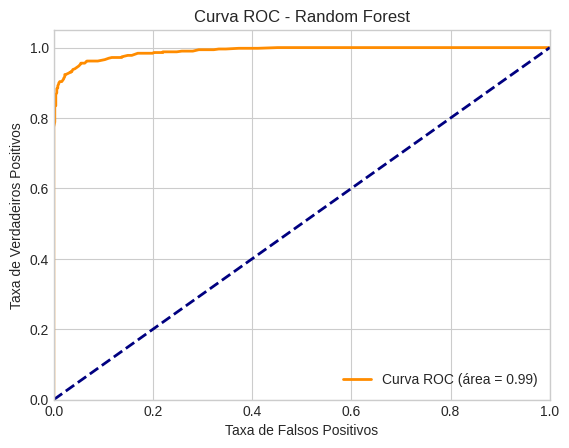

In [229]:
# prompt: faça uma gráfico de curva roc

from sklearn.metrics import roc_curve, auc

# Calcula as probabilidades das classes para o conjunto de teste
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Calcula a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plota a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()
